# HOW MUCH HAS AVERAGE TEMPERATURE CHANGED IN THE LAST CENTURY?


## 1.Preface

Earth is warming up; there are a lot of studies that report temperature rise during last centuries. [According](https://archive.ipcc.ch/ipccreports/tar/wg1/index.php?idp=5) to IPCC (The Intergovernmental Panel on Climate Change)  global average surface temperature has increased by 0.6 ± 0.2° over the 20th century. In this paper we will try to check out this fact using GHCN (Global Historical Climatology Network) [dataset](https://console.cloud.google.com/marketplace/details/noaa-public/ghcn-m). The GHCN-Monthly is a temperature dataset that contains monthly mean temperatures and is used for operational climate monitoring activities. It is comprised of climate records from over 7,000 stations.


## 2.Exploring dataset

Import modules and set up connection to dataset via Bigquery:

In [52]:
import db_dtypes
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
# client initialization
client = bigquery.Client()
# constructing reference to dataset
dataset_ref = client.dataset('ghcn_m', project='bigquery-public-data')
# get dataset object
dataset = client.get_dataset(dataset_ref)

Check list of tables in dataset:

In [4]:
for table in client.list_tables(dataset):
    print(table.table_id)

ghcnm_tavg
ghcnm_tavg_stations
ghcnm_tmax
ghcnm_tmax_stations
ghcnm_tmin
ghcnm_tmin_stations


Let's take a look on ghcnm_tavg table:

In [2]:
ghcnm_tavg_ref = dataset_ref.table('ghcnm_tavg')  # get table reference
ghcnm_tavg = client.get_table(ghcnm_tavg_ref)     # get table
client.list_rows(ghcnm_tavg, max_results=5).to_dataframe()

,id,year,element,value1,dmflag1,qcflag1,dsflag1,value2,dmflag2,qcflag2,...,qcflag10,dsflag10,value11,dmflag11,qcflag11,dsflag11,value12,dmflag12,qcflag12,dsflag12
0,10160355000,1931,TAVG,-9999,None,None,None,1035,None,None,...,None,1,1615,None,None,1,1125,None,None,1
1,10160355000,1933,TAVG,-9999,None,None,None,-9999,None,None,...,None,1,1545,None,None,1,1195,None,None,1
2,10160355000,1935,TAVG,925,None,None,1,1155,None,None,...,None,None,1555,None,None,1,1315,None,None,1
3,10160355000,1941,TAVG,1215,None,None,1,-9999,None,None,...,None,None,-9999,None,None,None,-9999,None,None,None
4,10160355000,1966,TAVG,-9999,None,None,None,-9999,None,None,...,None,None,1395,None,None,0,1165,None,None,0


Table contains 12 value_n columns (presumably one for each month), but they don't look like temperature numbers. So we should refer to table schema:

In [18]:
ghcnm_tavg.schema[2:4]

[SchemaField('element', 'STRING', 'NULLABLE', None, 'element type, monthly mean temperature="TAVG" monthly maximum temperature="TMAX" monthly minimum temperature="TMIN"', (), None),
 SchemaField('value1', 'INTEGER', 'NULLABLE', None, 'monthly value (MISSING=-9999). Temperature values are in hundredths of a degree Celsius, but are expressed as whole integers (e.g. divide by 100.0 to get whole degrees Celsius).', (), None)]

As we can see, table contains monthly mean temperature with values in hundredths of a degree Celsius, so we can treat them correctly. Also, we will use year and station id columns.

## 3.Annual mean temperature change in 20th century


### 3.1 Average temperature in 1900 and 2000

Let's compare average year temperature in 1900 and 2000. First we'll construct table with annual mean temperature. Also, this query discards rows with missing values:

In [4]:
query_annual_mean = """
          WITH annual_mean AS(
          SELECT id,year,(value1+value2+value3+value4+value5+value6+
                          value7+value8+value9+value10+value11+value12)
                         /100.0/12 AS mean_temperature
         FROM `bigquery-public-data.ghcn_m.ghcnm_tavg`
         WHERE value1 <> -9999 AND
               value2 <> -9999 AND
               value3 <> -9999 AND
               value4 <> -9999 AND
               value5 <> -9999 AND
               value6 <> -9999 AND
               value7 <> -9999 AND
               value8 <> -9999 AND
               value9 <> -9999 AND
               value10 <> -9999 AND
               value11 <> -9999 AND
               value12 <> -9999)
          """
query_view = """{}
                SELECT * 
                FROM annual_mean
                LIMIT 3
             """.format(query_annual_mean)
query_job = client.query(query_view)
query_job.to_dataframe().head()


,id,year,mean_temperature
0,10160355000,1967,17.741667
1,10160355000,1968,18.166667
2,10160355000,1969,17.550000


Now we can calculate mean temperature in 1900 and 2000:

In [13]:
query_1 = """{}
             SELECT year, AVG(mean_temperature) AS mean_temperature
             FROM annual_mean
             WHERE year IN (1900,2000)
             GROUP BY year
             ORDER BY year
          """.format(query_annual_mean)
query_job = client.query(query_1)
temp_df = query_job.to_dataframe()
print(temp_df, '\n')
print('Temperature change from 1900 to 2000: ',
      round(temp_df.mean_temperature[1]-temp_df.mean_temperature[0], 1), '°C')

   year  mean_temperature
0  1900         11.660771
1  2000         13.042306 

Temperature change from 1900 to 2000:  1.4 °C


### 3.2 Moving average

We have got about 1.4° of temperature rise. This is much higher than value reported by IPCC, so we should assume that 1900 or 2000 was not an 'average' year. This problem could be addressed by using moving average over decade:

In [14]:
query_2 = """{},
             moving_avg AS(
             SELECT year, AVG(AVG(mean_temperature)) OVER
                          (ORDER BY year DESC
                           ROWS BETWEEN 5 PRECEDING AND 5 FOLLOWING)
                           AS mean_temperature
             FROM annual_mean
             GROUP BY year)
             SELECT *
             FROM moving_avg
             WHERE year IN (1900,2000)
             ORDER BY year
          """.format(query_annual_mean)
query_job = client.query(query_2)
temp_df = query_job.to_dataframe()
print(temp_df, '\n')
print('Temperature change from 1900 to 2000: ',
      round(temp_df.mean_temperature[1]-temp_df.mean_temperature[0], 1), '°C')


   year  mean_temperature
0  1900         11.279154
1  2000         13.024359 

Temperature change from 1900 to 2000:  1.7 °C


### 3.3 Mean with matching stations

We have got 1.7°C of temperature change that is even higher. But what if difference is caused by new stations that have been implemented during 20th century? Let's check how many stations were there in 1900 and 2000:

In [80]:
query_3 = """{}
             SELECT year, COUNT(1) AS number_of_stations
             FROM annual_mean
             WHERE year IN (1900,2000)
             GROUP BY year
             ORDER BY year
          """.format(query_annual_mean)
query_job = client.query(query_3)
query_job.to_dataframe().head()

,year,number_of_stations
0,1900,1195
1,2000,2042


Amount of stations was almost doubled since 1900. What if some of them were built at warmer places? This time we are going to calculate mean temperature only with stations that have records for both 1900 and 2000:

In [15]:
query_4 = """{},
             moving_avg AS(
             SELECT year, AVG(AVG(mean_temperature)) OVER
                          (ORDER BY year DESC
                           ROWS BETWEEN 5 PRECEDING AND 5 FOLLOWING)
                           AS mean_temperature,
                           COUNT(id) as number_of_stations
             FROM annual_mean
             WHERE id IN (SELECT id
                          FROM annual_mean
                          WHERE year = 2000 AND
                                id IN
                                    (SELECT id
                                     FROM annual_mean
                                     WHERE year = 1900))
             GROUP BY year)
             SELECT *
             FROM moving_avg
             WHERE year IN (1900,2000)
             ORDER BY year
         """.format(query_annual_mean)
query_job = client.query(query_4)
temp_df = query_job.to_dataframe()
print(temp_df, '\n')
print('Temperature change from 1900 to 2000: ',
      round(temp_df.mean_temperature[1]-temp_df.mean_temperature[0], 2), '°C')

   year  mean_temperature  number_of_stations
0  1900         10.955694                 580
1  2000         11.906104                 580 

Temperature change from 1900 to 2000:  0.95 °C


This time we have got a lower value (0.95°) of difference in temperatures between 1900 and 2000. However, despite this, our estimation still higher than IPCC estimation. 

### 3.4 Temperature change and number of the observation stations

Finally, let's check how mean temperature was changing each year during 20th century:

In [12]:
query_5 = """{}
          SELECT year,AVG(mean_temperature ) AS mean_temperature,
               COUNT(1) AS number_of_stations
          FROM annual_mean
          WHERE  year BETWEEN 1900 AND 2000
          GROUP BY year
          """.format(query_annual_mean)
query_job = client.query(query_5)
df1 = query_job.to_dataframe()

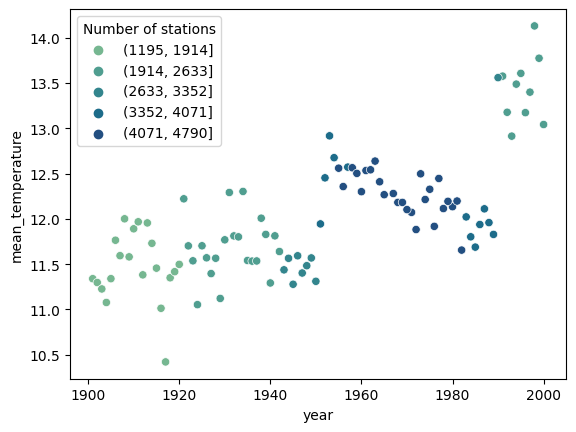

In [48]:
# create bins with number_of_stations
min_range = df1.number_of_stations.min()
max_range = df1.number_of_stations.max()
step = (max_range-min_range)//5
bins = range(min_range, max_range, step)
df1['binned'] = pd.cut(df1.number_of_stations, bins)
# draw graph
sns.scatterplot(x=df1.year, y=df1.mean_temperature, 
                hue=df1.binned, palette='crest')
plt.legend(title='Number of stations')
plt.show()

## 4. Climate change acceleration

According to the plot, strongest global warming period occurred in 1980-2000. Should we consider the possibility of climate change acceleration? [NOAA's 2021 Annual Climate Report ](https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202113) says that combined land and ocean temperature has increased at an average rate of  0.08° C per decade since 1880; however, the average rate of increase since 1981 has been more than twice as fast: 0.18 °C per decade. Let's try to figure out how our data match this assertion.

### 4.1 Rate of temperature increase in 1880 - 1980

In this section we will calculate moving average for annual temperature as we did it in 3.3:

In [42]:
query_6 = """{},
             moving_avg AS(
             SELECT year, AVG(AVG(mean_temperature)) OVER
                          (ORDER BY year DESC 
                          ROWS BETWEEN 5 PRECEDING AND 5 FOLLOWING)
                          AS mean_temperature,
                          COUNT(id) as number_of_stations
             FROM annual_mean
             WHERE id IN (SELECT id 
                          FROM annual_mean
                          WHERE year = 1980 AND
                                id IN
                                    (SELECT id
                                     FROM annual_mean
                                     WHERE year = 1880))
             GROUP BY year)
             SELECT *
             FROM moving_avg
             WHERE year IN (1880,1980)
             ORDER BY year
              """.format(query_annual_mean)
query_job = client.query(query_6)
df2 = query_job.to_dataframe()
print(df2.head(), '\n')
avg_rate_per_decade = round((df2.mean_temperature[1]-df2.mean_temperature[0])
                            /10,2)
print('Average rate per decade in 1880-1980: ', avg_rate_per_decade, '°C')

   year  mean_temperature  number_of_stations
0  1880         11.201956                 225
1  1980         11.909978                 225 

Average rate per decade in 1880-1980:  0.07 °C


### 4.2 Rate of temperature increase in 1981 - 2017

We will use the same query as above

In [44]:
query_7 = """{},
             moving_avg AS(
             SELECT year, AVG(AVG(mean_temperature)) OVER
                          (ORDER BY year DESC 
                          ROWS BETWEEN 5 PRECEDING AND 5 FOLLOWING)
                          AS mean_temperature,
                          COUNT(id) as number_of_stations
             FROM annual_mean
             WHERE id IN (SELECT id 
                          FROM annual_mean
                          WHERE year = 1981 AND
                                id IN
                                    (SELECT id
                                     FROM annual_mean
                                     WHERE year = 2017))
             GROUP BY year)
             SELECT *
             FROM moving_avg
             WHERE year IN (2017,1981)
             ORDER BY year
              """.format(query_annual_mean)
query_job = client.query(query_7)
df3 = query_job.to_dataframe()
print(df3.head(), '\n')
avg_rate_per_decade = round((df3.mean_temperature[1]-df3.mean_temperature[0])
                            /4,2)
print('Average rate per decade in 1981-2017: ', avg_rate_per_decade, '°C')

   year  mean_temperature  number_of_stations
0  1981         10.612800                1298
1  2017         11.776012                1298 

Average rate per decade in 1981-2017:  0.29 °C


## 5. Conclusion

Now we can compare results obtained from GHCN dataset to IPCC and NOAA data

|  | IPCC | NOAA|GHCN |
| --- | --- | --- | -- |
|Average temperature rise in 20th century | 0.6 ± 0.2° | 0.74° | 0.95°|
|Rate of temperature increase in 1880-1980, per decade | 0.1°|0.08°|0.07°|
|Rate of temperature increase in 1981-2017, per decade | 0.2°|0.18°|0.29°|

Therefore we have obtained values greater than estimation from other sources. There is problem with GHCN dataset  - it contains data from land surface stations only while IPCC and NOAA reports include ocean surface and atmospheric measurements. Also, some differences could be caused by different correction techniques and missing values handling.

## 6. Appendix

### 6.1 Weather stations distribution by area

In [53]:
query_8 = """
          SELECT
          CASE WHEN popcls = "R" THEN "Rural"
               WHEN popcls = "S" THEN "Suburban"
               ELSE "Urban"
          END AS area,
          COUNT(1) AS number_of_stations
          FROM `bigquery-public-data.ghcn_m.ghcnm_tavg_stations`
          WHERE popcls <> "None"
          GROUP BY popcls
          ORDER BY popcls
          """
query_job = client.query(query_8)
df4 = query_job.to_dataframe()
print(df4.head(), '\n')

       area  number_of_stations
0     Rural                3872
1  Suburban                1401
2     Urban                1947 



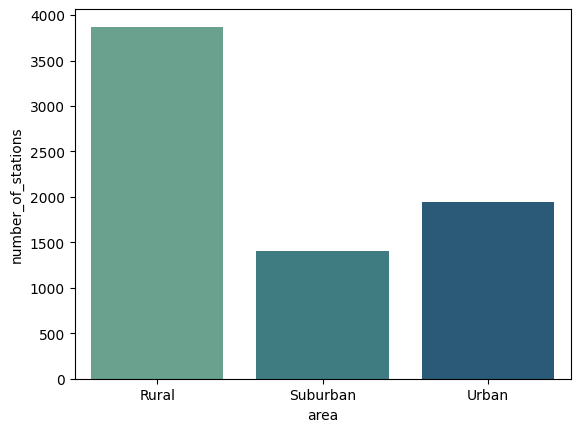

In [58]:
sns.barplot(x=df4.area, y=df4.number_of_stations, palette='crest')
plt.show()

### 6.2 Weather stations distribution by climat zone

In [30]:
query_9 = """
          SELECT
          CASE WHEN (latitude >= 0 AND latitude <=23.5)
                 OR (latitude <= 0 AND latitude >=-23.5) THEN "Tropic"
               WHEN (latitude > 23.5 AND latitude <= 40)
                 OR (latitude <-23.5 AND latitude >=-40) THEN "Subtropic"
               WHEN (latitude > 40 AND latitude <= 66)
                 OR (latitude <-40 AND latitude >=-66) THEN "Temperature"
               ELSE "Cold" 
               END AS climate_zone,
               COUNT(1) AS number_of_stations
          FROM `bigquery-public-data.ghcn_m.ghcnm_tavg_stations`
          GROUP BY climate_zone
          """
query_job = client.query(query_9)
df5 = query_job.to_dataframe()
print(df5.head(), '\n')

  climate_zone  number_of_stations
0    Subtropic                2841
1  Temperature                2947
2         Cold                 140
3       Tropic                1352 



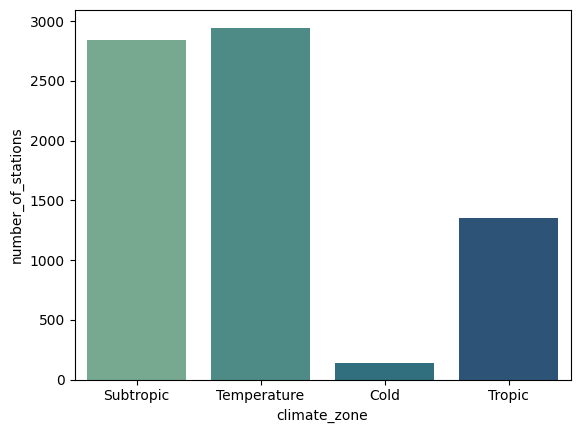

In [44]:
sns.barplot(x=df5.climate_zone, y=df5.number_of_stations, palette='crest')
plt.show()

### 6.3 Is urban area warmer than rural?

In [59]:
query_10 = """{},
              stations AS
              (SELECT
               CASE WHEN popcls = "R" THEN "Rural"
                    WHEN popcls = "S" THEN "Suburban"
                    ELSE "Urban"
                    END AS area, id
               FROM `bigquery-public-data.ghcn_m.ghcnm_tavg_stations`
               WHERE popcls <> "None")
               SELECT stations.area AS area,
                      AVG(annual_mean.mean_temperature) AS mean_temperature
               FROM stations JOIN annual_mean ON
                    stations.id = annual_mean.id
               GROUP BY stations.area
               ORDER BY stations.area DESC
           """.format(query_annual_mean)
query_job = client.query(query_10)
df6 = query_job.to_dataframe()
print(df6.head(), '\n')

       area  mean_temperature
0     Urban         14.158163
1  Suburban         12.946670
2     Rural         10.234168 



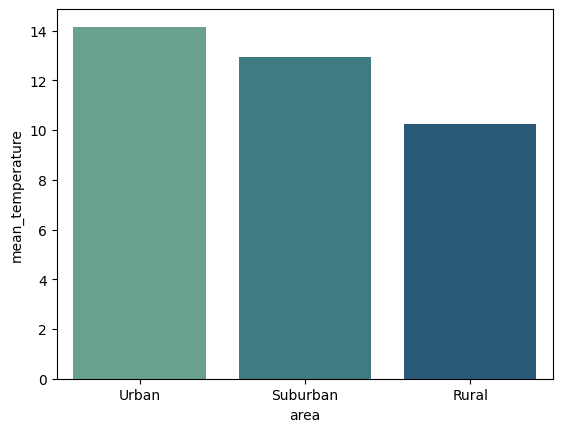

In [60]:
sns.barplot(x=df6.area, y=df6.mean_temperature, palette='crest')
plt.show()